In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv('A3/train.csv', index_col='ArticleId')
X = df['Text']
df['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y = df['Category']

df_test = pd.read_csv('A3/test.csv', index_col='ArticleId')
X_test = df_test['Text']
df_test['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_test = df_test['Category']

temp_complete_test = pd.concat([X, X_test])


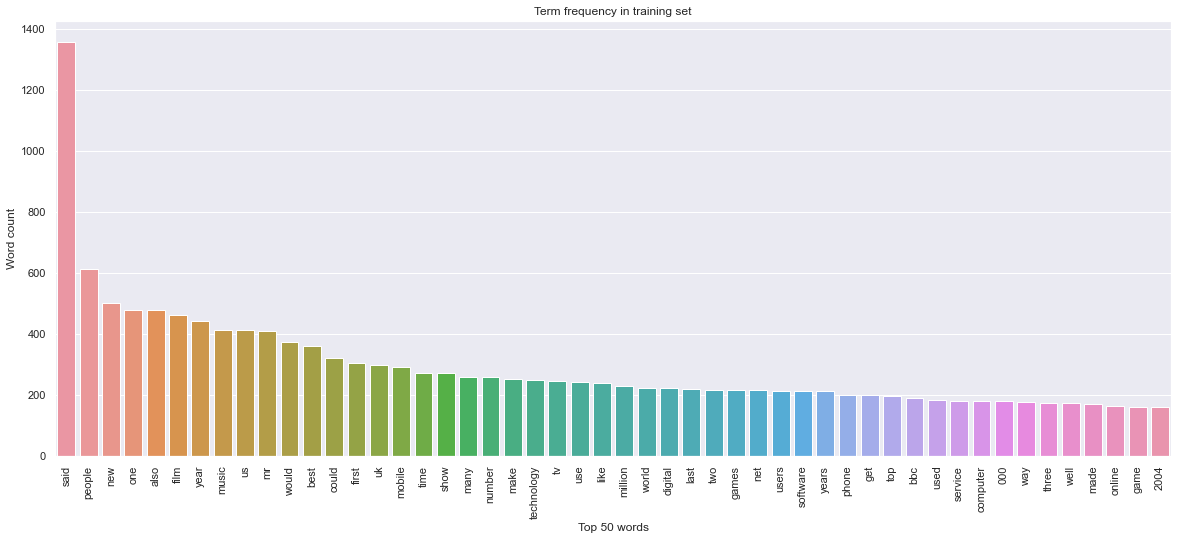

In [3]:
# Frequency count for dataset
vectorizer = CountVectorizer()
vectorizer.fit(temp_complete_test)
# Encode document
vector = vectorizer.transform(temp_complete_test)
prep_X_count = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=temp_complete_test.index)
#print(prep_X_count)

prep_X_train_count = prep_X_count[:428]
prep_X_test_count = prep_X_count[428:]

train_sum = prep_X_train_count.sum().sort_values(ascending=False)
test_sum = prep_X_test_count.sum().sort_values(ascending=False)

train_top_50 = train_sum.head(50)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(20,8)})
plot = sns.barplot(x=train_top_50.index, y=train_top_50.values)
plot.set_xlabel('Top 50 words')
plot.set_ylabel('Word count')
plot.set_title('Term frequency in training set')
plt.xticks(rotation = 90)
plt.show()

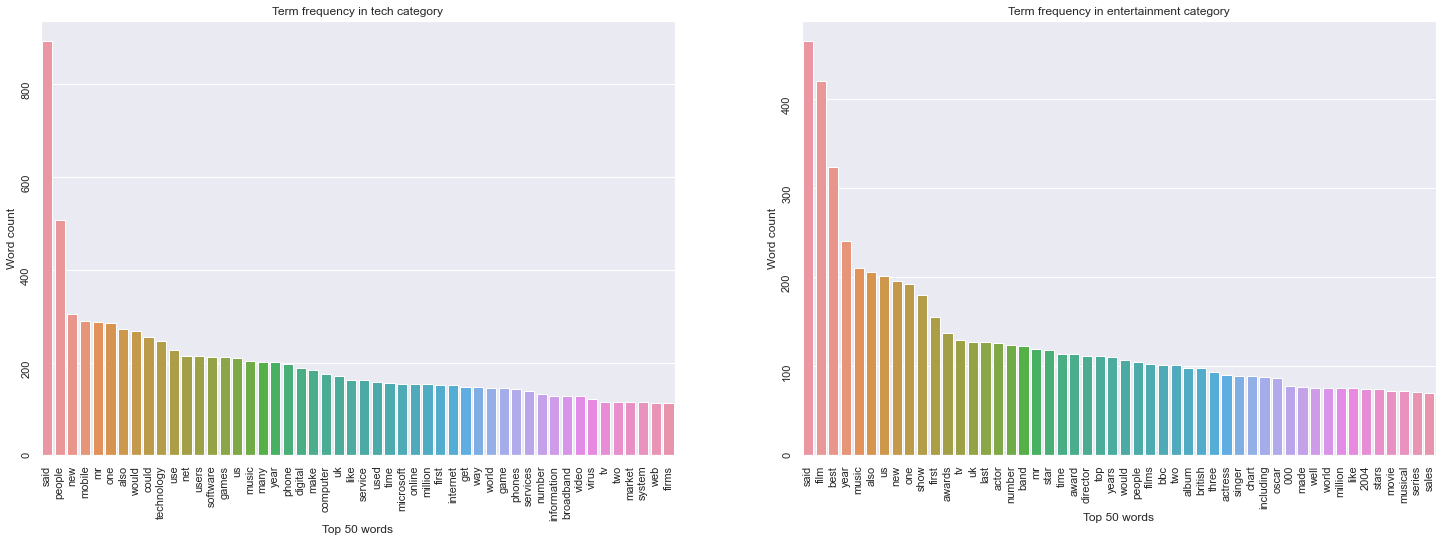

In [4]:
train_label_group = Y.groupby(Y)
train_tech, train_entertain = train_label_group.get_group(0).index, train_label_group.get_group(1).index

train_tech_sum = prep_X_count.loc[train_tech].sum().sort_values(ascending=False)
train_entertain_sum = prep_X_count.loc[train_entertain].sum().sort_values(ascending=False)

train_top_50_tech = train_tech_sum.head(50)
train_top_50_entertain = train_entertain_sum.head(50)

fig, ax = plt.subplots(ncols=2, figsize=(25, 8))
ax[0] = sns.barplot(x=train_top_50_tech.index, y=train_top_50_tech.values, ax=ax[0])
ax[0].set_xlabel('Top 50 words')
ax[0].set_ylabel('Word count')
ax[0].set_title('Term frequency in tech category')
ax[0].tick_params(labelrotation=90)

ax[1] = sns.barplot(x=train_top_50_entertain.index, y=train_top_50_entertain.values, ax=ax[1])
ax[1].set_xlabel('Top 50 words')
ax[1].set_ylabel('Word count')
ax[1].set_title('Term frequency in entertainment category')
ax[1].tick_params(labelrotation=90)
plt.show()

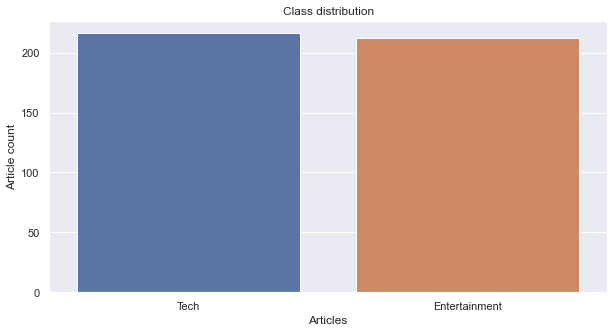

In [5]:
sns.set(rc = {'figure.figsize':(10,5)})
plot = sns.barplot(x=['Tech', 'Entertainment'], y=[train_tech.size, train_entertain.size])
plot.set_xlabel('Articles')
plot.set_ylabel('Article count')
plot.set_title('Class distribution')
plt.show()

In [6]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
# summarize
print(f'vector vocabulary - {vectorizer.vocabulary_}\n')

# encode document
vector = vectorizer.transform(X)
""" print(f'features\n {vectorizer.get_feature_names_out()}\n')
# summarize encoded vector
print(f'vector shape: {vector.shape}\n')
print(f'article vector\n {vector.toarray()}') """

prep_X = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X.index)
print(prep_X.shape)


vector vocabulary - {'lifestyle': 7222, 'governs': 5566, 'mobile': 7939, 'choice': 2494, 'faster': 4785, 'better': 1620, 'funkier': 5262, 'hardware': 5798, 'alone': 851, 'going': 5526, 'help': 5898, 'phone': 9010, 'firms': 4961, 'sell': 10811, 'handsets': 5771, 'research': 10186, 'suggests': 11791, 'instead': 6485, 'keen': 6877, 'get': 5432, 'customers': 3339, 'pushing': 9665, 'technology': 12090, 'sake': 10573, 'consumers': 3017, 'far': 4769, 'interested': 6528, 'fit': 4969, 'screen': 10721, 'size': 11124, 'onboard': 8515, 'memory': 7751, 'chip': 2491, 'inside': 6460, 'shows': 11024, 'depth': 3615, 'study': 11710, 'handset': 5770, 'maker': 7497, 'ericsson': 4459, 'historically': 5973, 'industry': 6387, 'much': 8075, 'focus': 5047, 'using': 12845, 'said': 10567, 'dr': 4006, 'michael': 7816, 'bjorn': 1684, 'senior': 10831, 'advisor': 701, 'media': 7714, 'consumer': 3016, 'enterprise': 4405, 'lab': 6993, 'stop': 11613, 'saying': 10637, 'technologies': 12089, 'change': 2406, 'lives': 7307

In [7]:
vectorizer = TfidfVectorizer()
vectorizer.fit(temp_complete_test)
# summarize
# print(f'vector vocabulary - {vectorizer.vocabulary_}\n')

# encode document
vector = vectorizer.transform(temp_complete_test)
""" print(f'features\n {vectorizer.get_feature_names_out()}\n')
# summarize encoded vector
print(f'vector shape: {vector.shape}\n')
print(f'article vector\n {vector.toarray()}') """

temp_complete_test_prep = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=temp_complete_test.index)
print(temp_complete_test_prep.head())

prep_X_train = temp_complete_test_prep[:428]
prep_X_test = temp_complete_test_prep[428:]
print(prep_X_test.shape)
print(prep_X_train.shape)

            00       000  000th  001st  0051  007  0100  0130  028  0400  ...  \
ArticleId                                                                 ...   
1976       0.0  0.020253    0.0    0.0   0.0  0.0   0.0   0.0  0.0   0.0  ...   
1797       0.0  0.000000    0.0    0.0   0.0  0.0   0.0   0.0  0.0   0.0  ...   
1866       0.0  0.000000    0.0    0.0   0.0  0.0   0.0   0.0  0.0   0.0  ...   
1153       0.0  0.000000    0.0    0.0   0.0  0.0   0.0   0.0  0.0   0.0  ...   
342        0.0  0.000000    0.0    0.0   0.0  0.0   0.0   0.0  0.0   0.0  ...   

           zombie  zombies  zone  zonealarm  zones  zoom  zooms   zooropa  \
ArticleId                                                                   
1976          0.0      0.0   0.0        0.0    0.0   0.0    0.0  0.000000   
1797          0.0      0.0   0.0        0.0    0.0   0.0    0.0  0.000000   
1866          0.0      0.0   0.0        0.0    0.0   0.0    0.0  0.000000   
1153          0.0      0.0   0.0        0.0    

# Neural Network

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import warnings

warnings.filterwarnings('ignore')

np.random.seed(1)

init_weigths = np.random.uniform(0., 0.1, 14927)
hid_units = [5,20,40]
results = []

for hid_unit in hid_units:
    clf = MLPClassifier(hidden_layer_sizes=(hid_unit,), solver='sgd', learning_rate_init=0.01, max_iter=100)
    clf.coefs_ = init_weigths

    clf.fit(prep_X_train,Y)

    preds = clf.predict(prep_X_test)
    score = clf.score(prep_X_test, Y_test)

    loss = log_loss(Y_test, preds)
    results.append([hid_unit, loss, score])

print(results)

[[5, 0.3400344659350677, 0.9905660377358491], [20, 2.220446049250313e-16, 1.0], [40, 0.6800689318701351, 0.9811320754716981]]


[]

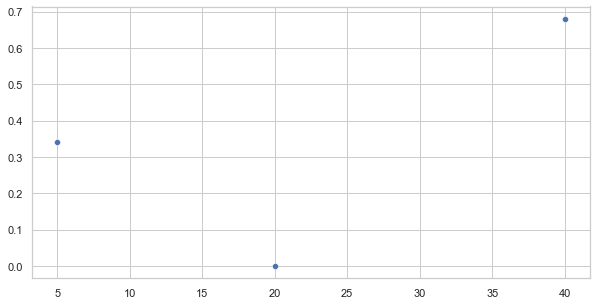

In [9]:
sns.set_style('whitegrid')
results = np.array(results).T
plot = sns.scatterplot(x=results[0], y=results[1])
plt.plot()

In [11]:
from sklearn import svm

C = [0.01, 0.1, 0.2, 0.5, 1, 10]

for i in C:
    clf = svm.SVC(C = i, kernel = 'linear')
    clf.fit(prep_X_train, Y)

    preds = clf.predict(prep_X_test)

    predtrain = clf.score(prep_X_train, Y)
    predtest =  clf.score(prep_X_test, Y_test)

    print("Training accuracy: " + str(predtrain))
    print("Test accuracy: " + str(predtest))
    print("Regularization parameter: " + str(i))
    print(" ")


Training accuracy: 0.5046728971962616
Test accuracy: 0.42452830188679247
Regularization parameter: 0.01
 
Training accuracy: 0.9929906542056075
Test accuracy: 0.9716981132075472
Regularization parameter: 0.1
 
Training accuracy: 0.9953271028037384
Test accuracy: 0.9811320754716981
Regularization parameter: 0.2
 
Training accuracy: 0.9976635514018691
Test accuracy: 0.9905660377358491
Regularization parameter: 0.5
 
Training accuracy: 1.0
Test accuracy: 0.9905660377358491
Regularization parameter: 1
 
Training accuracy: 1.0
Test accuracy: 0.9905660377358491
Regularization parameter: 10
 


F1 score:                   0.9838056680161944
Training accuracy:          1.0
Test accuracy:              0.9833679833679834
Regularization parameter:   1
Training proportion:        0.1
 
F1 score:                   0.9740932642487047
Training accuracy:          1.0
Test accuracy:              0.9732620320855615
Regularization parameter:   1
Training proportion:        0.3
 
F1 score:                   0.9860139860139859
Training accuracy:          1.0
Test accuracy:              0.9850187265917603
Regularization parameter:   1
Training proportion:        0.5
 
F1 score:                   0.9826589595375723
Training accuracy:          1.0
Test accuracy:              0.9813664596273292
Regularization parameter:   1
Training proportion:        0.7
 
F1 score:                   1.0
Training accuracy:          1.0
Test accuracy:              1.0
Regularization parameter:   1
Training proportion:        0.9
 


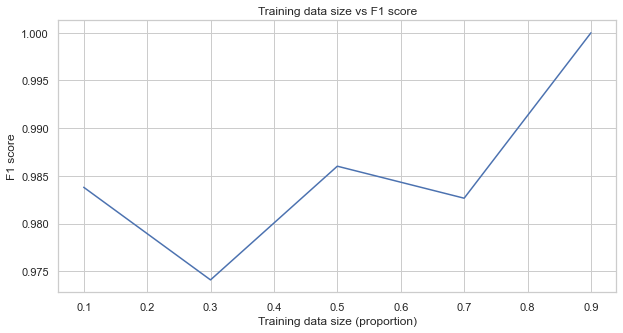

In [45]:
from sklearn.metrics import f1_score

m = [0.1, 0.3, 0.5, 0.7, 0.9]
N = len(temp_complete_test_prep)
Ytotal = Y.append(Y_test)
Cv = 1
F1s = []

for i in m:
    
    XTRAIN = temp_complete_test_prep[:int(i*N)]
    XTEST = temp_complete_test_prep[int(i*N):]
    YTRAIN = Ytotal[:int(i*N)]
    YTEST = Ytotal[int(i*N):]
    
    clf = svm.SVC(C = Cv, kernel = 'linear')
    clf.fit(XTRAIN, YTRAIN)

    predtrain = clf.score(XTRAIN, YTRAIN)
    predtest =  clf.score(XTEST, YTEST)
    
    preds = clf.predict(XTEST)
    F1 = f1_score(YTEST, preds)
    F1s.append(F1)

    print("F1 score:                   " + str(F1))
    print("Training accuracy:          " + str(predtrain))
    print("Test accuracy:              " + str(predtest))
    print("Regularization parameter:   " + str(Cv))
    print("Training proportion:        " + str(i))
    print(" ")

plot = sns.lineplot(x=m, y=F1s)
plot.set_xlabel('Training data size (proportion)')
plot.set_ylabel('F1 score')
plot.set_title('Training data size vs F1 score')
plt.show()
